In [1]:
import eventDrivenSimulation as eds
import simpy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import show as sh
import requests
import folium
import haversine
import math
import bibliothek as bib
import random
import simulation as sm

## Data Generation

In [2]:
CONFIG = {}

CONFIG['LAT'] = 51.34053598409240
CONFIG['LON'] = 12.381419774766130
CONFIG['RADIUS'] = 500
CONFIG['NUM_UES'] = 400
CONFIG['URL'] = 'https://pqos-api-test.radiolab.dit.htwk-leipzig.de' 

In [3]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)

ul_query_string = CONFIG['URL'] + '/generate_scenario' + \
                                  '?lat=' + str(CONFIG['LAT']) + \
                                  '&lon=' + str(CONFIG['LON']) + \
                                  '&radius=' + str(CONFIG['RADIUS']) + \
                                  '&num_ues=' + str(CONFIG['NUM_UES']) + \
                                '&cell_type=NGMN3600'

ul_response_data = requests.get(ul_query_string).json()
ue_data = ul_response_data['ue_data']
cell_data=ul_response_data['cell_data']

eds.plot_map(CONFIG,cell_data)

In [4]:
df_ue=pd.DataFrame(ue_data)

In [5]:
df_cell = pd.DataFrame(cell_data)

In [6]:
sectors=df_cell['pci'].unique()

In [7]:
bs_dict={}
for i in df_cell.index:
    bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lon'],df_cell.loc[i]['lat']]})

In [8]:
user_dataframe=pd.DataFrame()
x=np.array([])
for i in df_ue['id']:
    dic=df_ue.loc[i]['cell_info']
    powers={}
    pos=df_ue.loc[i]['pos']
    powers.update({'lat':pos[0]})
    powers.update({'lon':pos[1]})
    for i in dic:
        powers.update({i['pci']:i['dl_rx_power']})
    x=np.append(x,powers)
user_dataframe = pd.DataFrame.from_records(x)

## Preprocessing & CoMP Calculations

Settings for the CoMP Calculations: 
* noise power = -104 dBm

P=vector with receiving powers from all PCIs (N)

**SINR without CoMP**: $\frac{P_{0}}{P_{N}+P_{1:N}}$

**SINR with CoMP (2 coord. PCIs)** : $\frac{(\sqrt{P_{0}}+\sqrt{P_{1}})^2}{P_{N}+P_{2:N}}$

In [9]:
noise=np.power(10,-104/10) #https://www.sciencedirect.com/topics/engineering/noise-power -> 10MHz bandwidth (50PRBs)
cluster=sectors #all the cells are put in one cluster

In [10]:
df=user_dataframe.copy()
SINR_list=np.array([])
SINRwithCoMP_list=np.array([])
SINRwithCoMP_phaseshiftList=np.array([])
tp_1_list=np.array([])
tp_2_list=np.array([])
for i in np.arange(0, len(df)):
    P=df.loc[i,:][2:] #goes through file line by line and selects the line
    P=np.power(10, P/10) # calculate the linear values for capacity calculations
    P=P.sort_values(ascending=False) # sort values by their order
    A=np.sqrt(P) #calculate the amplitude
    index=P.index.values #Extract all index values 
    index=index.astype(np.int) #PCIen as integer
    A=np.array(A)
    P=np.array(P)
    SINR= P[0]/(np.sum(P[1:])+noise)
    SINRwithCoMP= np.power(np.sum(A[0:2]),2)/(np.sum(P[2:])+noise)
    #phi=random.gauss(0, math.pi)
    phi=random.gauss(0, math.pi/4)
    SINRwithCoMP_phaseshift=10*np.log10((np.power(A[0]+A[1]*np.cos(phi),2)+np.power(A[1]*np.sin(phi),2))/(np.sum(P[2:])+noise))
    
    SINR_list=np.append(SINR_list,10*np.log10(SINR)) #appends the calculated elements
    SINRwithCoMP_list=np.append(SINRwithCoMP_list,10*np.log10(SINRwithCoMP))
    SINRwithCoMP_phaseshiftList=np.append(SINRwithCoMP_phaseshiftList,SINRwithCoMP_phaseshift)

    tp_1_list=np.append(tp_1_list,index[0])
    tp_2_list=np.append(tp_2_list,index[1])

##### Building the dataframe

In [11]:
df['lat']=user_dataframe['lat']
df['lon']=user_dataframe['lon']
df['SINR [dB]']=SINR_list
df['SINR-CoMP [dB]']=SINRwithCoMP_list
df['SINR-CoMP with phaseshift [dB]']=SINRwithCoMP_phaseshiftList
df['TP1']=tp_1_list.astype(int)
df['TP2']=tp_2_list.astype(int)
df['qos']=np.zeros(len(user_dataframe)) #not needed here -> all users are best effort -> 0
df['id']=np.arange(0,len(user_dataframe))

#### Define general parameters for the simulation

In [12]:
max_prb=50 #number of prbs defined by the system bandwidth
ue_nr=15 #number of ues per pci
metric=[1,1] #defines the exponents of the metric (standard metric is pf ->[1,1])

#### Sort out PCIs that have less than ue_nr users -> edge of the Scenario

In [13]:
np.unique(df['TP1'])

array([132, 133, 134, 318, 319, 320, 631, 774, 775, 776, 901])

In [14]:
#check if the number of users (positions) for the serving pci is >10
df_filter=df.groupby('TP1')
count=0
for i in df['TP1'].unique():
    k=df_filter.get_group(i)
    if(len(k)<ue_nr):
        cluster=np.delete(cluster,count) #delete cells with less than 10 positions
        df=df[df['TP1']!=i]
    count+=1

#### Define a cluster

In [15]:
sectors= np.array(df['TP1'].unique())
print('pci options for cluster:',sectors)

pci options for cluster: [134 319 775 776 132 318 774 133]


In [16]:
#cluster=[134,776,319]
cluster=[133,775]
#cluster=sectors
#cluster=[133,775,319]

if following code says "sinr out of range" thats because the sinr is just restricted up to 30 dB

In [17]:
index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

size=4000 #size of each packet that arrives from a user [Bit]
env=simpy.Environment()

#ues are initialized 
ue_dict=eds.df_to_ue_lists(df,cluster,6,env) #ue_dict is dict with all users from the dataframe from the defined cluster

# select only ue_nr of users from given index 
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

#### Different PRB sizes-> Evaluation

In [18]:
import simulation as sm

In [ ]:
cluster=[319,775]
x_res2=np.array([])
cluster_nr=0
mu_range=np.arange(2,15,1)
prb_range=np.arange(5,30,2)
s_l={}
speicher={}

for prb_number in prb_range:
    prb_number_comp={}
    for i in cluster:
        prb_number_comp[i]=prb_number
    for mu in mu_range:    
        print(mu)
        ue_noCoMP, ue_comp, ue_all, index=sm.run_simulation('deterministic',df,cluster,mu,ue_nr,6,max_prb,prb_number_comp,metric)
        df_res=eds.ue_to_df(ue_all)
        x=np.array((df_res['mR gain']-1)*100)
        x_res2=np.append(x_res2,np.mean(x))
        cluster_nr+=1

        liste=np.array([])

        for i in ue_all:
            liste=np.append(liste,((i.mR2/i.mR)-1)*100)
            speicher.update({mu:liste.mean()})    
   
    l=np.array([])
    l2=np.array([])
    for i in mu_range:
        x=speicher.get(i)
        l=np.append(l,x.mean())
    s_l.update({prb_number_comp[cluster[0]]:l})



2


C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:240: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:270: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


3
4
5
6
7
8
9
10
11
12
13
14
2
3
4
5
6
7
8
9
10
11
12
13
14
2
3
4
5
6
7
8
9
10
11
12
13
14
2
3
4
5
6
7
8
9
10
11
12
13
14
2
3
4
5
6
7
8
9
10
11
12
13
14
2
3
4
5
6
7
8
9
10
11
12
13
14
2
3
4
5
6
7
8
9
10
11
12
13
14
2
3
4
5
6
7
8
9
10
11
12
13
14
2
3
4
5
6
7
8
9
10
11
12


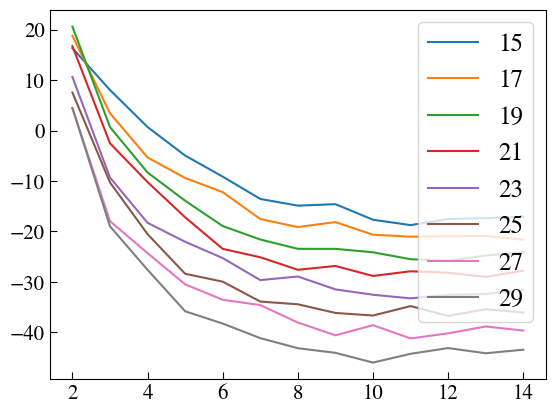

In [21]:
count=0
for i in prb_range:
    plt.plot(mu_range,list(s_l[i]),label=str(i))
    plt.legend()
    count+=1

In [91]:
for i in ue_all:
    #print(i.mR2/i.mR)
    print(i.queue.level)

1732000.0
1928000.0
1384251.0
805796.0
1355980.0
639850.0
1947500.0
1666100.0
999023.0
1538500.0
1662500.0
1510850.0
1889390.0
1805250.0
1458416.0
834600.0
0
989920.0
1608170.0
1925350.0
1335192.0
0
885354.0
0
1602560.0
1632820.0
1290543.0
1099419.0
644993.0
1825175.0


In [76]:
s_l[25]

array([17.30130922, 17.28451762, 17.09225378, 16.75616775, 17.10992741,
       16.62701158, 17.06824786, 17.18383275, 16.81275483, 16.99349376,
       15.88056136, 17.09770504, 16.73507058, 17.01018448, 17.19154687,
       17.18385049, 17.09303604, 17.04576531, 17.43263011])